<a href="https://colab.research.google.com/github/SlackerJerry/ta-lib-tutorial/blob/main/garch_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as opt
import yfinance as yf

     |████████████████████████████████| 6.4 MB 36.4 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
ticker = '^GSPC' # sid = SPY
start = '2016-12-31'
end = '2021-06-25'

SPX = yf.download('^GSPC', start , end, interval = '1d')
VIX = yf.download('^VIX',  start , end, interval = '1d')
prices = yf.download(ticker, start, end)['Close']

SPX['log_returns'] = np.log(SPX['Adj Close']) - np.log(SPX['Adj Close'].shift(1))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
# # Rolling Volatility with lookback_size = 30
# SPX['std30'] = SPX['log_returns'][1:].rolling(window=30, center=False).std()
# SPX = SPX.dropna()
# SPX['Annualized_Volatility'] = SPX['std30'] * (255**0.5) 
# vol_annuailzed = SPX['Annualized_Volatility']

In [ ]:
# Compute unconditional statistics
#log_returns = SPX['log_returns'].to_numpy()[1:] # Covert to np array

# log_returns = np.array(prices)[1:]/np.array(prices)[:-1] - 1
log_returns = SPX['log_returns'][1:]


mean = np.average(log_returns)
H_uncond = np.std(log_returns)**2

print("Unconditional Mean:", mean)
print("Unconditional Variance:", H_uncond)

Unconditional Mean: 0.0005651752401904771
Unconditional Variance: 0.00015857207873961194


In [ ]:
# MLE

def garch_mle(params):
  mu = params[0]
  omega = params[1]
  alpha = params[2]
  beta = params[3]
  #T = len(log_returns)
  
  # long-term variance and volatility (std)
  H_0 = omega / (1 - alpha - beta)
  std_0 = H_0**(.5)

  # mean-corrected log-return and conditional volatility
  u = log_returns - mu # Residuals u_t
  sigma = abs(u) # realized volatility as absolute value of residuals: sigma = |u_t|
  
  # Initialzing the variance
  H = np.zeros(T)
  for t in range(T):
    if t==0:
      H[t] = H_0
    else:
      H[t] = omega + alpha * u[t-1]**2 + beta * H[t-1]
  
  # Negative likelihood function
  log_likelihood = np.sum( -np.log(H) - u**2 / (2 * H))
  NLL = -np.sum( -np.log(H) - u**2 / (2 * H))

  return NLL   

In [ ]:
# Initialzing parameters
# mu_0 = mean
# omgea_0 = H_uncond, unconditional variance or long-term variance
# alpha_0 = 0, beta_0 = 0

params = [mean, H_uncond, 0, 0] 
T = len(log_returns)

In [ ]:
# Optimizing MLE

res = opt.minimize(garch_mle,params, method='Nelder-Mead')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in log


In [ ]:
# Estimated params (optimal)

params_estimated = res.x
mu = res.x[0]
omega = res.x[1]
alpha = res.x[2]
beta = res.x[3]
NLL = float(res.fun)

In [ ]:
# Backtesting with estimated params

H_0 = omega / (1 - alpha - beta)
u = log_returns - mu
sigma = abs(u)
H = np.zeros(T)


for t in range(T):
  if t==0:
    H[t] = H_0
  else:
    H[t] = omega + alpha * u[t-1]**2 + beta * H[t-1]

In [ ]:
# Print estimated params

print('GARCH(1,1) Model Parameters')
print('GARCH model parameters')
print('')
print('mu '+str(round(mu, 6)))
print('omega '+str(round(omega, 6)))
print('alpha '+str(round(alpha, 4)))
print('beta '+str(round(beta, 4)))
print('long-run volatility '+str(round(H_0, 4)))
print('Negatove Log-Likelihood '+str(round(NLL, 4)))

GARCH(1,1) Model Parameters
GARCH model parameters

mu 0.001066
omega 2e-06
alpha 0.1338
beta 0.7315
long-run volatility 0.0
Negatove Log-Likelihood -10475.2366


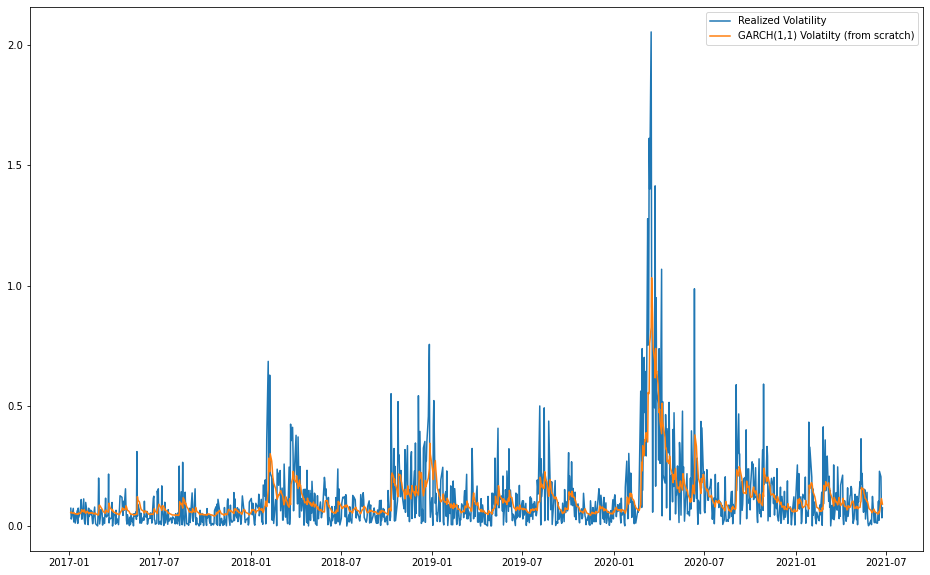

In [ ]:
#visualising the results
plt.figure(figsize=(16,10))
plt.rc('xtick', labelsize = 10)
plt.plot(log_returns.index,sigma * (255**.5), label='Realized Volatility')
plt.plot(log_returns.index,H**(.5) * (255**.5), label='GARCH(1,1) Volatilty (from scratch)')
# 255 ** .5 for annualizing


# plt.plot(log_returns.index, vol_annuailzed[1:],
        #  label ='Rolling Volatility With 30 Time Periods By Annualized Standard Deviation')
plt.legend()
plt.show()

In [ ]:
!pip install arch

     |████████████████████████████████| 902 kB 17.3 MB/s 
     |████████████████████████████████| 9.8 MB 33.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
from arch import arch_model
model = arch_model(log_returns, mean='Zero', vol='GARCH', p=1, q=1)

In [ ]:
model_fit = model.fit(update_freq=5)
print(model_fit.summary())


Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3797.1932131884673
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
                       Zero Mean - GARCH Model Results                        
Dep. Variable:            log_returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                3797.19
Distribution:                  Normal   AIC:                          -7588.39
Method:            Maximum Likelihood   BIC:                          -7573.31
                                        No. Observations:                 1126
Date:                Wed, Apr 13 2022   Df Residuals:                     1126
Time:                        20:19:07   Df Model:                            0
                              Volatility Model                              
   

/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001586. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


In [ ]:
pd.DataFrame(model_fit.params)

,params
omega,0.000003
alpha[1],0.200000
beta[1],0.780000


In [ ]:
model_fit.conditional_volatility

Date
2017-01-04    0.004117
2017-01-05    0.004787
2017-01-06    0.004601
2017-01-09    0.004707
2017-01-10    0.004794
                ...   
2021-06-18    0.004956
2021-06-21    0.007566
2021-06-22    0.009300
2021-06-23    0.008710
2021-06-24    0.007912
Name: cond_vol, Length: 1126, dtype: float64

In [ ]:
# Backtesting with estimated params
m2 = 0
o2 = 0.000003
a2 = 0.200000
b2 = 0.780000

H2_0 = o2 / (1 - a2 - b2)
u2 = log_returns - m2
sigma2 = abs(u2)
H2 = np.zeros(T)



for t in range(T):
  if t==0:
    H2[t] = H2_0
  else:
    H2[t] = o2 + a2 * u2[t-1]**2 + b2 * H2[t-1]

In [ ]:
H2

array([1.50000000e-04, 1.26511605e-04, 1.01797930e-04, ...,
       8.56906799e-05, 7.50640254e-05, 6.17848948e-05])

In [ ]:
realized_vol = sigma.to_numpy()

In [ ]:
# As a sanity check, model_fit.conditional_volatility 
# should gives the same value as H2

df = []

for i in range(len(H2)):
  df.append( [model_fit.conditional_volatility[i], H2[i]**.5, realized_vol[i]] )

check = pd.DataFrame(df, 
                     columns = ['GARCH package', 'GARCH from Scratch', 'Realized Volatility'])
check

,GARCH package,GARCH from Scratch,Realized Volatility
0,0.004117,0.012247,0.004640
1,0.004787,0.011248,0.001837
2,0.004601,0.010089,0.002445
3,0.004707,0.009212,0.004621
4,0.004794,0.008469,0.001066
...,...,...,...
1121,0.004956,0.004874,0.014277
1122,0.007566,0.007512,0.012839
1123,0.009300,0.009257,0.004045
1124,0.008710,0.008664,0.002150


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error,\
r2_score, mean_squared_error

In [ ]:
r2_score(model_fit.conditional_volatility, realized_vol)

-0.11622774987455653

In [ ]:
# Print estimated params

print('GARCH(1,1) Model Parameters')
print('GARCH model parameters')
print('')
print('mu '+str(round(mu, 6)))
print('omega '+str(round(omega, 6)))
print('alpha '+str(round(alpha, 4)))
print('beta '+str(round(beta, 4)))
print('long-run volatility '+str(round(H_0, 4)))
print('Negative log-likelihood '+str(round(NLL, 4)))

GARCH(1,1) Model Parameters
GARCH model parameters

mu 0.001066
omega 2e-06
alpha 0.1338
beta 0.7315
long-run volatility 0.0
Negative log-likelihood -10475.2366


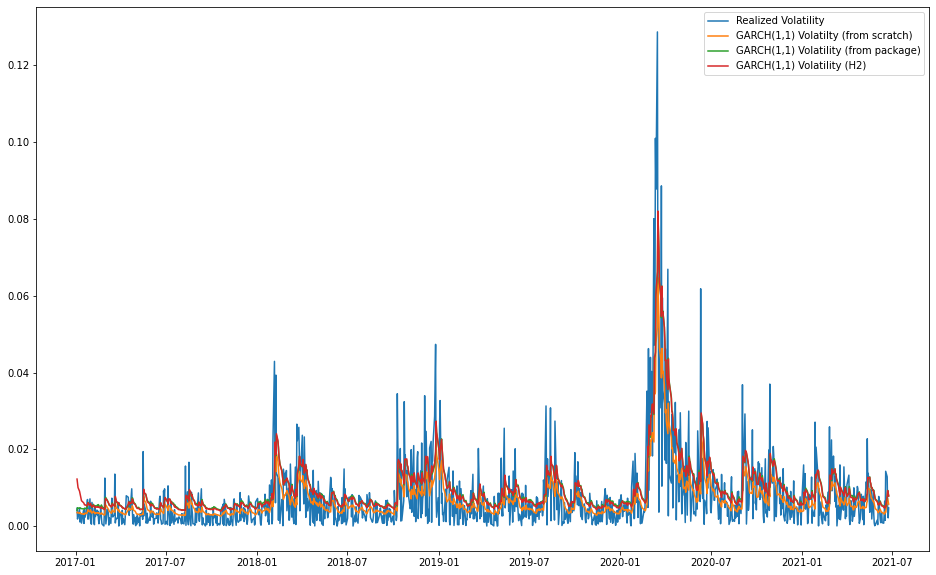

In [ ]:
#visualising the results
plt.figure(figsize=(16,10))
plt.rc('xtick', labelsize = 10)
plt.plot(prices.index[1:],sigma, label='Realized Volatility')
plt.plot(prices.index[1:],H**(.5), label='GARCH(1,1) Volatilty (from scratch)')
plt.plot(prices.index[1:],model_fit.conditional_volatility , label='GARCH(1,1) Volatility (from package)')
plt.plot(prices.index[1:],H2**0.5 , label='GARCH(1,1) Volatility (H2)')

plt.legend()
plt.show()